# Creating Ramachandran plots with Biopython

In this notebook, I am playing with Biopython's PDB functionalities. My objective is to represent a Ramachandran plot for a protein structure (you guessed right: a TRPA1 structure). You can run it in <a href="https://colab.research.google.com/github/edu9as/web-scraping/blob/master/ramachandran-plot-and-nglview-with-biopython.ipynb">Google Colab</a>

## 1. Install some libraries

In [1]:
!pip install Bio
!pip install nglview

^C


ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\edunu\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\edunu\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\edunu\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\edunu\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\edunu\Anaconda3\lib\site-packages\pip\_inter

## 2. Load libraries

In [2]:
import requests
import Bio
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import nglview as nv
from Bio.PDB import PDBParser
from Bio.PDB.vectors import calc_dihedral

## 3. Obtaining structure of TRPA1 from PDB

First, I am retrieving a TRPA1 structure (PDB ID: 3J9P) from RCSB PDB database using ```requests``` library.

In [3]:
base_pdb_url = "https://files.rcsb.org/view/{}.pdb"
trpa1_pdb_id = "3J9P"
trpa1_pdb = requests.get(base_pdb_url.format(trpa1_pdb_id)).text

## 4. Parsing the PDB file

Then, to get the information from the PDB file, I am using ```PDBParser``` from **Biopython.PDB**.

In [4]:
parser = PDBParser()

After writing TRPA1 PDB structure to a file, I am parsing this file with the previous parser. I don't know how to do this without saving a PDB file, but it would be great:

In [5]:
f = open("3j9p.pdb", "w")
f.write(trpa1_pdb)
f.close()

trpa1 = parser.get_structure("3J9P", file = "3j9p.pdb")

## 5. Calculate dihedral angles

Because I want to represent a Ramachandran plot, I am interested in obtaining the torsion angles in the backbone of TRPA1 protein. There is a very nice function ```calc_dihedral``` in **Bio.PDB.vectors** that will be truly helpful.

First, I am defining a tiny function that has a 4-position atom list as input and returns the dihedral angle that these four atoms form, thanks to their spatial coordinates (```get_vector()``` method).

```atoms_prec``` is a list that keeps track of the last atoms that have been examined. To understand the importance of this list in my code, it is important to keep in mind some characteristics of dihedral angles that appear in Ramachandran plots:

- These angles are formed only by N, C and alpha C (Ca) in the protein backbone. Then, only these atom types might be stored in this list.

- *phi* is the dihedral angle formed by N(i)-Ca(i)-C(i)-N(i+1), while *psi* is that formed by C(i-1)-N(i)-Ca(i)-C(i). Then, we only want to compute the dihedral angle for each group of four atoms if the first and last positions in the list are either N or C.

In [6]:
def dihedral_from_list(atoms):
    return calc_dihedral(atoms[0][2].get_vector(), 
                         atoms[1][2].get_vector(), 
                         atoms[2][2].get_vector(), 
                         atoms[3][2].get_vector())

atoms_prec = ["", "", "", ""]

dihedr = {"phi": {}, "psi": {}}


The angles will be stored in a dictionary that contains a dictionary for *phi* angles and another dictionary for *psi* angles. In these two inner dictionaries, the keys are the amino-acid IDs.

In [7]:
for i, atom in enumerate(trpa1.get_atoms()):
    if atom.get_id() not in ("C", "CA", "N"): continue
    atoms_prec = atoms_prec[1:] + [(atom.get_id(), atom.parent.get_id()[1], atom)]
    #print(atoms_prec)
    if i < 3: continue
    id_ = str(atoms_prec[1][1])
    if int(atoms_prec[0][1]) + 1 != int(atoms_prec[3][1]): continue
    if (atoms_prec[0][0] == "N") & (atoms_prec[3][0] == "N"):
        dihedr["phi"][id_] = dihedral_from_list(atoms_prec)
    elif (atoms_prec[0][0] == "C") & (atoms_prec[3][0] == "C"):
        dihedr["psi"][id_] = dihedral_from_list(atoms_prec)

After a few seconds, all the dihedral angles have been computed. Now, we can create a Pandas dataframe with the recently created dictionary:

In [8]:
df = pd.DataFrame(dihedr)

## 6. Ramachandran plot

And finally, let's see what these pairs of *phi* and *psi* angles look like in a Ramachandran plot:

Text(0.5, 1.0, 'Ramachandran plot of TRPA1 (3J9P in PDB)')

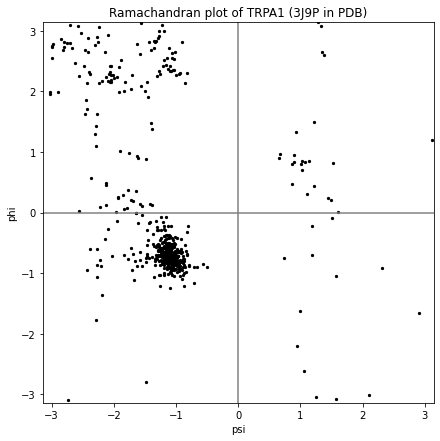

In [9]:
df.plot.scatter("psi", "phi", s = 5, c = "#000000", figsize = (7,7))
plt.vlines(0, ymin = -4, ymax = 4, color = "grey")
plt.hlines(0, xmin = -4, xmax = 4, color = "grey")
plt.xlim(-3.14, 3.14)
plt.ylim(-3.14, 3.14)
plt.title("Ramachandran plot of TRPA1 (3J9P in PDB)")

Note that the angles here are shown in radians. We can see a sparse cloud of points at the top left corner of this plot (high phi, low psi); this is the region of beta-sheets. Oppositely, there is a great concentration of points near (*phi* = -0.75, *psi* = -1), which is the region of alpha-helices. 

## 7. Taking a look at TRPA1 3D structure

Does what we observed in the Ramachandran plot make sense? Thanks to **nglview**, we can examine this 3D structure.

**```WARNING: NGLVIEW DOES NOT WORK CURRENTLY IN GOOGLE COLAB```**

In [10]:
view = nv.show_biopython(trpa1)
view

NGLWidget()

We see that there are a lot of alpha helices in TRPA1 tridimensional structure, and only a few beta-sheets. This is in accordance with what we observed in the Ramachandran plot.

Finally, let's render a pretty image of TRPA1:

In [11]:
view.render_image()

Image(value=b'', width='99%')